In [1]:
import pymolpro as pmp
import numpy as np
import math
import os

In [2]:

maindb=pmp.database.Database()

for xyz in os.listdir('xyzfiles'): 
    if xyz.endswith('.xyz'):
        f=open(f'/home/stuart/Hydrocarbons/xyzfiles/{xyz}')
        maindb.add_molecule(name=xyz[:-4], geometry=f.read())

db=pmp.database.run(maindb,method='locali,pipek;ccsd',basis='cc-pVTZ', parallel=1, postamble='put,xml')

In [3]:
def dictbuilder(orbital,v):
    oid,noid=orbital.ID,f'-{orbital.ID}'
    #build the grid using n points and evaluate
    points=orbital.grid(n)
    values=orbital.evaluate(points,values=True)
    moments=orbital.second_moment_eigenvalues
    
    moments=np.append(moments,float(v.xpath("//orbitals/orbital[@ID='"+orbital.ID+"']/@energy")[0]))
    moments=np.append(moments,float(orbital.kinetic_energy))
    orbiaddfeats.update({oid:moments})
    orbiaddfeats.update({f'-{oid}':moments})
    #values=values**2
    #puts them into the dictionaries
    orbitaldt.update({oid:values})
    orbitaldt.update({f'-{oid}':values})
    #probably unnecessary, but works
    if orbital.ID not in griddt:
        griddt[orbital.ID] = {}
        griddt[f'-{orbital.ID}']={}
    #xyz is arbitrary, just to keep consistency and easy to call later
    griddt[oid].update({i:{
        'x':float(points[i][0]),
        'y':float(points[i][1]),
        'z':float(points[i][2])
        }for i in range(len(points))})
    griddt[f'-{oid}'].update({i:{
        'x':float(points[i][0]),
        'y':float(points[i][1]),
        'z':float(points[i][2])
        }for i in range(len(points))})


def chkorbid(o1,o2):
    if o1.startswith('-'):
        chko1=o1[1:]
    else:
        chko1=o1
    if o2.startswith('-'):
        chko2=o2[1:]
    else:
        chko2=o2
    if chko1==chko2:
        return True
    else: 
        return False




In [4]:
#settings
#number of grid points to use (will increase input features n**3 and compute time the same way so dont go too high
n=4

#alpha in the error function

a=1

#the arrays are stored in a list until the end of the calculations to then be np.stack()
selffeaturelist=[]
selfaddfeatslist=[]
selflabellist=[]


for k,v in db.projects.items():
    #used to store the density key = orbital ID, values=orbital.evaluate
    orbitaldt={}
    #stores the XYZ coordinates for the grid to later be used for the distances. key= orbital id, values= 'x','y','z'
    griddt={}
    #additional features, second moment eigenvalues, orbital energy, kinetic energy.
    orbiaddfeats={}
    for orbital in v.orbitals():
        #stores the evaluated orbital and grid coordinates in different dictionaries
        dictbuilder(orbital,v)
    
    for pair in v.xpath("//pair"):
        temp=pmp.element_to_dict(pair)
        oid1,oid2=temp['orbital1'],temp['orbital2']
        if chkorbid(oid1,oid2)==True:
            selffeaturelist.append(np.array(orbitaldt[oid1]))
            selfaddfeatslist.append(np.array(orbiaddfeats[oid1]))
            selflabellist.append(float(temp['energy']))
        else:
            continue
                                     

selffeatures=np.stack(selffeaturelist)
selfaddfeatures=np.stack(selfaddfeatslist)
selflabels=np.stack(selflabellist) 


In [ ]:
import tensorflow as tf
import keras

split=int(0.8*len(selffeaturelist))

trainselffeats=np.stack(selffeaturelist[:split])
trainselfaddfeats=np.stack(selfaddfeatslist[:split])
trainselflabels=np.stack(selflabellist[:split])
testfeats=np.stack(selffeaturelist[split:])
testaddfeats=np.stack(selfaddfeatslist[split:])
testselflabels=np.stack(selflabellist[split:])



# Define NN1
class NN1(tf.keras.Model):
    def __init__(self):
        super(NN1, self).__init__()
        self.dense1 = tf.keras.layers.Dense(640, activation='softmax')
        self.dense2 = tf.keras.layers.Dense(3)
    
    def call(self, inputs):
        x = self.dense1(inputs)
        return self.dense2(x)

# Define NN2
class NN2(tf.keras.Model):
    def __init__(self):
        super(NN2, self).__init__()
        self.dense1 = tf.keras.layers.Dense(100, activation='relu')
        self.dense2 = tf.keras.layers.Dense(1) 
    
    def call(self, inputs):
        x = self.dense1(inputs)
        return self.dense2(x)

def predict(x1, x2):
    # Forward pass through NN1
    nn1_output = nn1(x1)
    
    # Combine NN1 output with additional features for NN2 input
    nn2_input = tf.concat([nn1_output, x2], axis=1)
    
    # Forward pass through NN2 to get the final prediction
    y_pred = nn2(nn2_input)
    
    return y_pred    

losstracker={}

# Instantiate the models
nn1 = NN1()
nn2 = NN2()

#dynamic learning rate
init_lr=0.01

# Optimizers
optimizer = tf.keras.optimizers.Adam()


# Loss function
loss_fn = tf.keras.losses.Huber()

# Training loop
epoch = 0
while testloss>10**-8:
    with tf.GradientTape() as tape:
        
        #dyn_lr=init_lr * 0.9995 ** epoch 
        #optimizer.learning_rate.assign(dyn_lr)
        
        # Forward pass through NN1
        nn1_output = nn1(trainselffeats)
        
        # Combine NN1 output with additional features for NN2 input
        nn2_input = tf.concat([nn1_output, trainselfaddfeats], axis=1)
        
        # Forward pass through NN2
        y_pred = nn2(nn2_input)
        
        # Calculate loss
        loss = loss_fn(trainselflabels, y_pred)
    
    # Compute gradients and apply updates
    gradients = tape.gradient(loss, nn1.trainable_variables + nn2.trainable_variables)
    optimizer.apply_gradients(zip(gradients, nn1.trainable_variables + nn2.trainable_variables))

    if (epoch+1)%10==0:
        predictions=predict(testfeats,testaddfeats)
        testloss=loss_fn(testselflabels, predictions)
        losstracker.update({epoch:math.log10(loss_fn(testselflabels, predictions))})
        if testloss>10**-3:
            optimizer.learning_rate.assign(0.01)
        elif testloss>10**-4:
            optimizer.learning_rate.assign(0.005)
        elif testloss>10**-5:
            optimizer.learning_rate.assign(0.001)
        elif testloss>10**-6:
            optimizer.learning_rate.assign(0.0005)
        elif testloss>10**-7:
            optimizer.learning_rate.assign(0.0001)
        elif testloss>10**-8:
            optimizer.learning_rate.assign(0.000001)
        
    
    
    
    # Print loss
    print(f'Epoch {epoch + 1}, Loss: {loss.numpy()}')
    epoch+=1


Epoch 1, Loss: 0.04306051880121231
Epoch 2, Loss: 0.031098587438464165
Epoch 3, Loss: 0.021304866299033165
Epoch 4, Loss: 0.013556062243878841
Epoch 5, Loss: 0.0077682542614638805
Epoch 6, Loss: 0.0038196109235286713
Epoch 7, Loss: 0.0015193783910945058
Epoch 8, Loss: 0.0006059097358956933
Epoch 9, Loss: 0.0007445977535098791
Epoch 10, Loss: 0.0015733548207208514
Epoch 11, Loss: 0.0027179212775081396
Epoch 12, Loss: 0.024690745398402214
Epoch 13, Loss: 0.03268149495124817
Epoch 14, Loss: 0.020861748605966568
Epoch 15, Loss: 0.00585206551477313
Epoch 16, Loss: 0.0006229391437955201
Epoch 17, Loss: 0.006593699101358652
Epoch 18, Loss: 0.01405336707830429
Epoch 19, Loss: 0.014279433526098728
Epoch 20, Loss: 0.008042861707508564
Epoch 21, Loss: 0.0017300236504524946
Epoch 22, Loss: 0.00040645463741384447
Epoch 23, Loss: 0.003856525057926774
Epoch 24, Loss: 0.00738808186724782
Epoch 25, Loss: 0.007258744444698095
Epoch 26, Loss: 0.004066535737365484
Epoch 27, Loss: 0.0009486172930337489
Epo

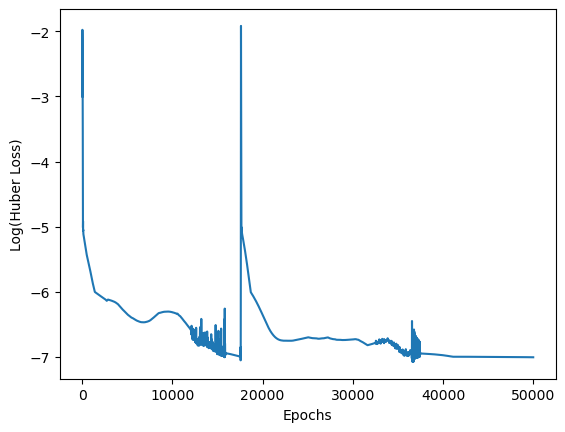

In [6]:
import matplotlib.pyplot as plt

plt.plot(losstracker.keys(),losstracker.values())
plt.xlabel('Epochs')
plt.ylabel('Log(Huber Loss)')
plt.savefig('test-loss-epochs-3outputnn1.png')
plt.show()

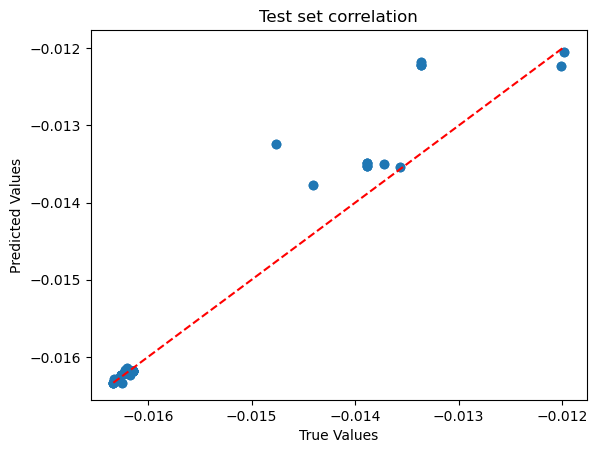

In [7]:
nn1.save('alkeneselfnn1_model.keras')
nn2.save('alkeneselfnn2_model.keras')
predictions=predict(testfeats,testaddfeats)

plt.scatter(testselflabels,predictions)
plt.plot((min(testselflabels),max(testselflabels)),(min(testselflabels),max(testselflabels)),c='red',linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Test set correlation')
plt.savefig('testselfset.png')
plt.show()